## Importing Libreries

In [61]:
import cv2
import pywt
import numpy as np
import imageio as iio
from matplotlib import pyplot as plt

### Loading the image

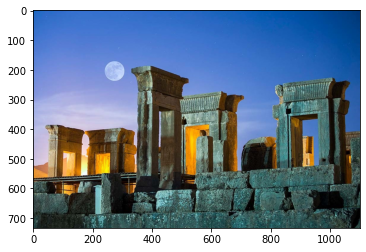

In [62]:
img = iio.imread("Q3.jpg").astype("float64")
plt.imshow(img.astype("uint8"));

### Making noisy image

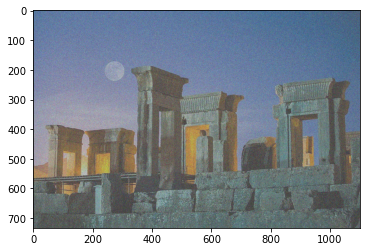

In [63]:
mu, sigma = 0, 40 # mean and standard deviation
noise = np.random.normal(mu, sigma, size=img.shape)
img_noisy = img.copy() + noise
def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*255
plt.imshow(scale(img_noisy).astype("uint8"));

#### Implemented wavelet with gaussian kernal

which I didn't used, but the pre implemented wavelet with haar is similar and gets the lowpass and highpass images vertically then downsamples and do it horizontally too, so you have LL,LH, HL,HH in the out put of function

In [64]:
#wavelet with gaussian
def my_wavelet(img,sigma=1,k=21):
    L = cv2.GaussianBlur(img,ksize=(k,1),sigmaX=sigma,sigmaY=0)
    H = img-L
    
    LL = cv2.GaussianBlur(L,ksize=(1,k),sigmaX=0,sigmaY=sigma)
    LH = L - LL
    
    HL = cv2.GaussianBlur(H,ksize=(1,k),sigmaX=0,sigmaY=sigma)
    HH = H - HL
    return np.vstack(( np.hstack((LL,LH)),np.hstack((HL,HH)) ))

#plt.figure(figsize=(16,10));
#plt.figure(dpi=120)
#s = 2
#k = img_noisy.shape[0]//2+1
#plt.imshow(my_wavelet(img_noisy,k=k,sigma=s).astype("uint8"),);

#### wavelet first layar

In [65]:
temp = pywt.dwt2(img_noisy[:,:,0], 'haar')[0]
LL = np.zeros((temp.shape[0],temp.shape[1],3))
LH = LL.copy()
HL = LL.copy()
HH = LL.copy()
for i in range(3):
    coeffs2 = pywt.dwt2(img_noisy[:,:,i], 'haar')
    LLt, (LHt, HLt, HHt) = coeffs2
    LL[:,:,i] = LLt
    LH[:,:,i] = LHt
    HL[:,:,i] = HLt
    HH[:,:,i] = HHt

#### second layar of wavelet

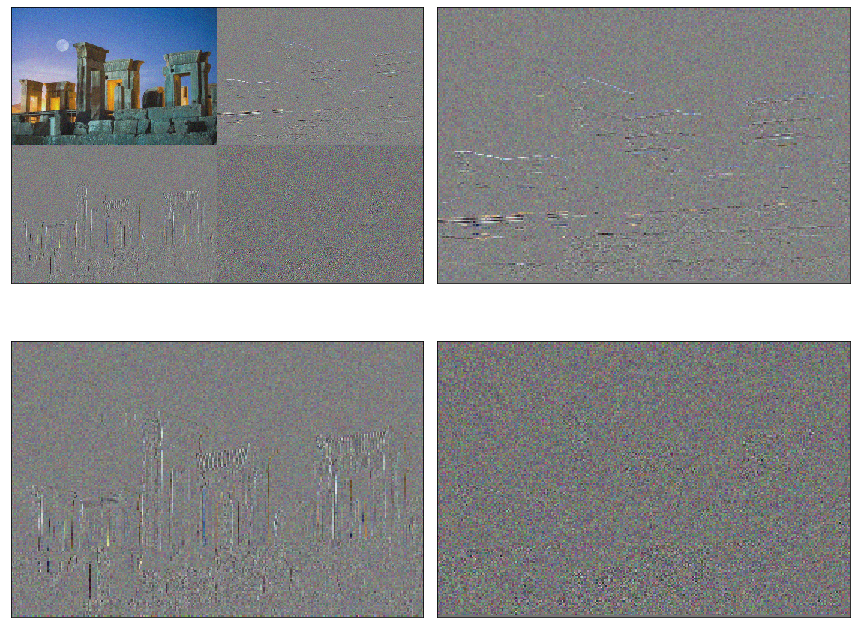

In [66]:
temp = pywt.dwt2(LL[:,:,0], 'haar')[0]
LLLL = np.zeros((temp.shape[0],temp.shape[1],3))
LLLH = LLLL.copy()
LLHL = LLLL.copy()
LLHH = LLLL.copy()
for i in range(3):
    coeffs2 = pywt.dwt2(LL[:,:,i], 'haar')
    LLt, (LHt, HLt, HHt) = coeffs2
    LLLL[:,:,i] = LLt
    LLLH[:,:,i] = LHt
    LLHL[:,:,i] = HLt
    LLHH[:,:,i] = HHt

fig = plt.figure(figsize=(12, 10))
allLLLL = np.vstack(( np.hstack((scale(LLLL),scale(LLLH))),np.hstack((scale(LLHL),scale(LLHH))) ))
for i, a in enumerate([allLLLL, LLLH, LLHL, LLHH]):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(scale(a).astype("uint8"), interpolation="nearest", cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

### Soft and Hard Shrinking functions

In [67]:
def soft(img,l):
    out = img.copy()
    
    out[img[:,:,0]>l] = img[img[:,:,0]>l] - l
    out[img[:,:,1]>l] = img[img[:,:,1]>l] - l
    out[img[:,:,2]>l] = img[img[:,:,2]>l] - l
    
    out[np.abs(img[:,:,0])<l] = 0
    out[np.abs(img[:,:,1])<l] = 0
    out[np.abs(img[:,:,2])<l] = 0
    
    out[img[:,:,0]<-l] = img[img[:,:,0]<-l] + l
    out[img[:,:,1]<-l] = img[img[:,:,1]<-l] + l
    out[img[:,:,2]<-l] = img[img[:,:,2]<-l] + l
    
    return out


def hard(img,l):
    out = img.copy()
    out[np.abs(img[:,:,0])<l] = 0
    out[np.abs(img[:,:,1])<l] = 0
    out[np.abs(img[:,:,2])<l] = 0
    return out

### VisoShrink

##### soft

In [68]:
VLLLL = LLLL.copy()
l_viso = sigma*np.sqrt(2*np.log(LLLH.shape[0]*LLLH.shape[1])) # viso value from lectures
VLLLH = soft(LLLH,l_viso)
VLLHL = soft(LLHL,l_viso)
VLLHH = soft(LLHH,l_viso)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_viso = sigma*np.sqrt(2*np.log(HH.shape[0]*HH.shape[1]))
VLH = soft(LH,l_viso)
VHL = soft(HL,l_viso)
VHH = soft(HH,l_viso)

Viso_soft = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Viso_soft[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

##### hard

In [69]:
VLLLL = LLLL.copy()
l_viso = sigma*np.sqrt(2*np.log(LLLH.shape[0]*LLLH.shape[1]))
VLLLH = hard(LLLH,l_viso)
VLLHL = hard(LLHL,l_viso)
VLLHH = hard(LLHH,l_viso)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(VHH.shape)
VLL = tVLL[1:368,:,:]

l_viso = sigma*np.sqrt(2*np.log(HH.shape[0]*HH.shape[1]))
VLH = hard(LH,l_viso)
VHL = hard(HL,l_viso)
VHH = hard(HH,l_viso)


Viso_hard = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Viso_hard[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

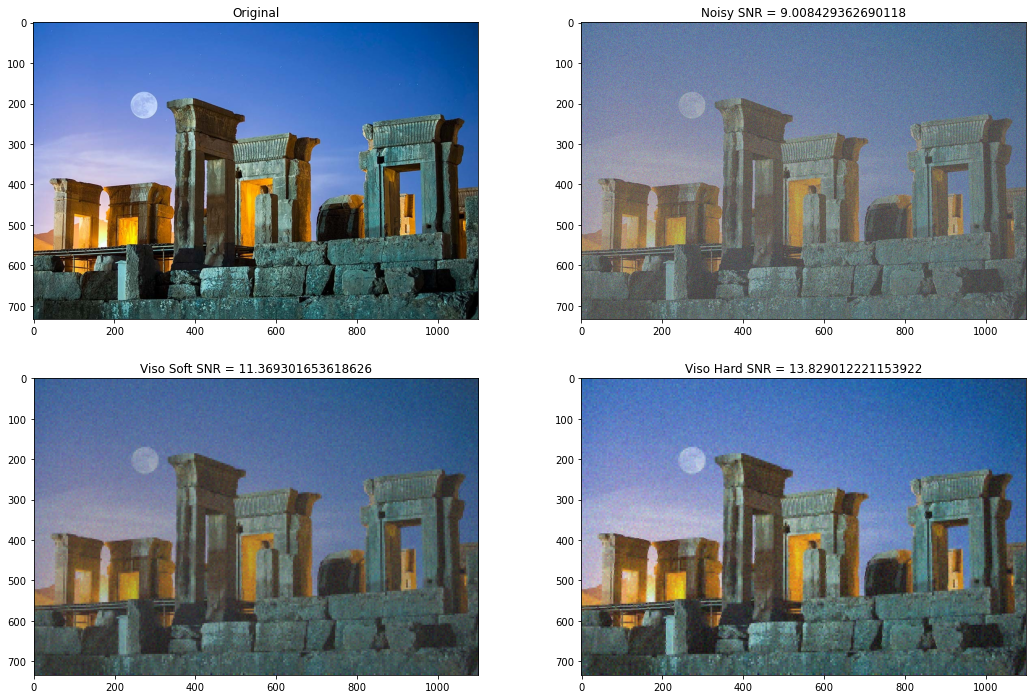

In [70]:
def SNR(x,y):
    m,n,c = x.shape
    x = scale(x[:m,:n,:])
    y = scale(y[:m,:n,:])
    a = np.sum(x**2)
    b = np.sum((x-y)**2)
    return 10*np.log10(a/b)

plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(img.astype("uint8"))
plt.title("Original")
plt.subplot(222)
plt.imshow(scale(img_noisy).astype("uint8"));
plt.title("Noisy SNR = "+str(SNR(img,img_noisy)))
plt.subplot(223)
plt.imshow(scale(Viso_soft).astype("uint8"));
plt.title("Viso Soft SNR = "+str(SNR(img,Viso_soft)))
plt.subplot(224)
plt.imshow(scale(Viso_hard).astype("uint8"));
plt.title("Viso Hard SNR = "+str(SNR(img,Viso_hard)));

### Bayes Shrink

##### soft

In [71]:
VLLLL = LLLL.copy()
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(LLLH)**2-sigma**2)) # bayes value from slides
VLLLH = soft(LLLH,l_bayes)
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(LLHL)**2-sigma**2))
VLLHL = soft(LLHL,l_bayes)
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(LLHH)**2-sigma**2))
VLLHH = soft(LLHH,l_bayes)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(LH)**2-sigma**2))
VLH = soft(LH,l_bayes)
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(HL)**2-sigma**2))
VHL = soft(HL,l_bayes)
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(HH)**2-sigma**2))
VHH = soft(HH,l_bayes)

Bayes_soft = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Bayes_soft[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

##### hard

In [72]:
VLLLL = LLLL.copy()
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(LLLH)**2-sigma**2))
VLLLH = hard(LLLH,l_bayes)
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(LLHL)**2-sigma**2))
VLLHL = hard(LLHL,l_bayes)
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(LLHH)**2-sigma**2))
VLLHH = hard(LLHH,l_bayes)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(LH)**2-sigma**2))
VLH = hard(LH,l_bayes)
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(HL)**2-sigma**2))
VHL = hard(HL,l_bayes)
l_bayes = sigma**2/np.sqrt(max(1e-20,np.std(HH)**2-sigma**2))
VHH = hard(HH,l_bayes)

Bayes_hard = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Bayes_hard[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

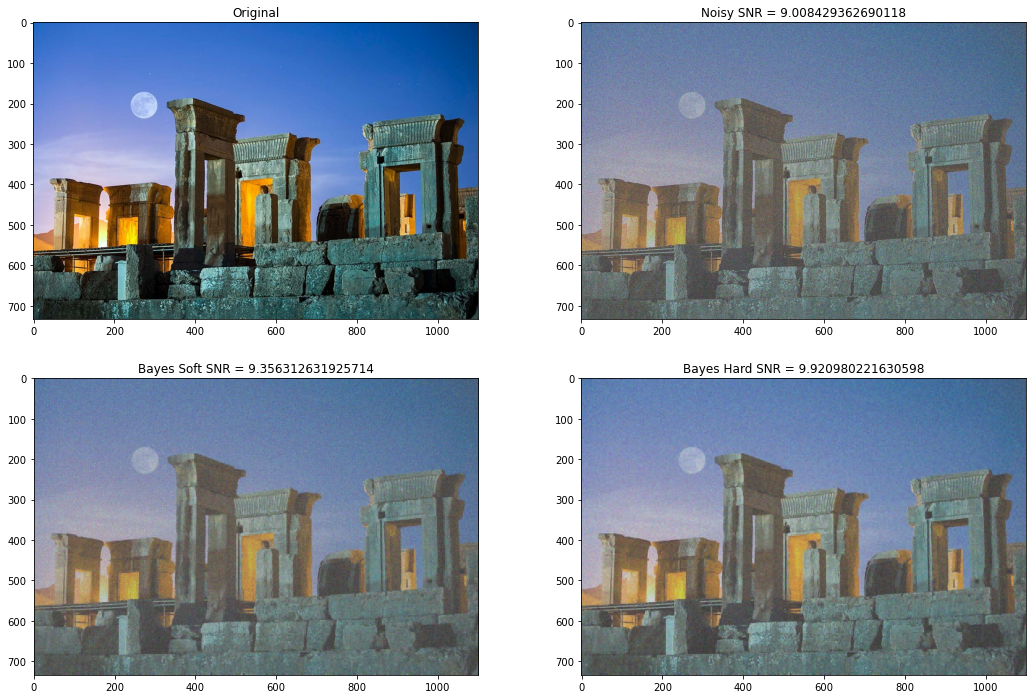

In [73]:
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(img.astype("uint8"))
plt.title("Original")
plt.subplot(222)
plt.imshow(scale(img_noisy).astype("uint8"));
plt.title("Noisy SNR = "+str(SNR(img,img_noisy)))
plt.subplot(223)
plt.imshow(scale(Bayes_soft).astype("uint8"));
plt.title("Bayes Soft SNR = "+str(SNR(img,Bayes_soft)))
plt.subplot(224)
plt.imshow(scale(Bayes_hard).astype("uint8"));
plt.title("Bayes Hard SNR = "+str(SNR(img,Bayes_hard)));

### Histograms

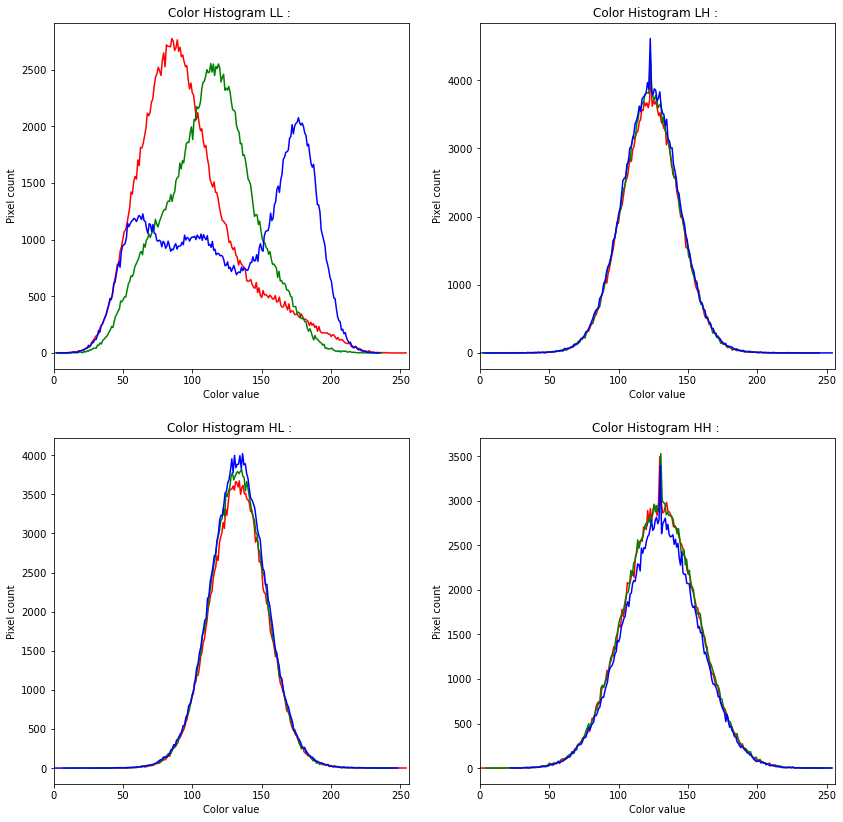

In [74]:
fig = plt.figure(figsize = (14, 14))
colors = ['red','green','blue']

temp = scale(LL) #LL histogram
ax1 = plt.subplot(2,2,1)
plt.xlim([0, 256])
for i in range(3):
    histogram, bins = np.histogram(temp[:,:,i],bins=256)
    plt.plot(bins[0:-1], histogram, color=colors[i])
plt.title("Color Histogram LL : ")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

temp = scale(LH) #LH histogram
ax2 = plt.subplot(2,2,2)
plt.xlim([0, 256])
for i in range(3):
    histogram, bins = np.histogram(temp[:,:,i],bins=256)
    plt.plot(bins[0:-1], histogram, color=colors[i])
plt.title("Color Histogram LH : ")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

temp = scale(HL) #HL histogram
ax1 = plt.subplot(2,2,3)
plt.xlim([0, 256])
for i in range(3):
    histogram, bins = np.histogram(temp[:,:,i],bins=256)
    plt.plot(bins[0:-1], histogram, color=colors[i])
plt.title("Color Histogram HL : ")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

temp = scale(HH) #HH histogram
ax2 = plt.subplot(2,2,4)
plt.xlim([0, 256])
for i in range(3):
    histogram, bins = np.histogram(temp[:,:,i],bins=256)
    plt.plot(bins[0:-1], histogram, color=colors[i])
plt.title("Color Histogram HH : ")
plt.xlabel("Color value")
plt.ylabel("Pixel count");

#### layar 2 histogram

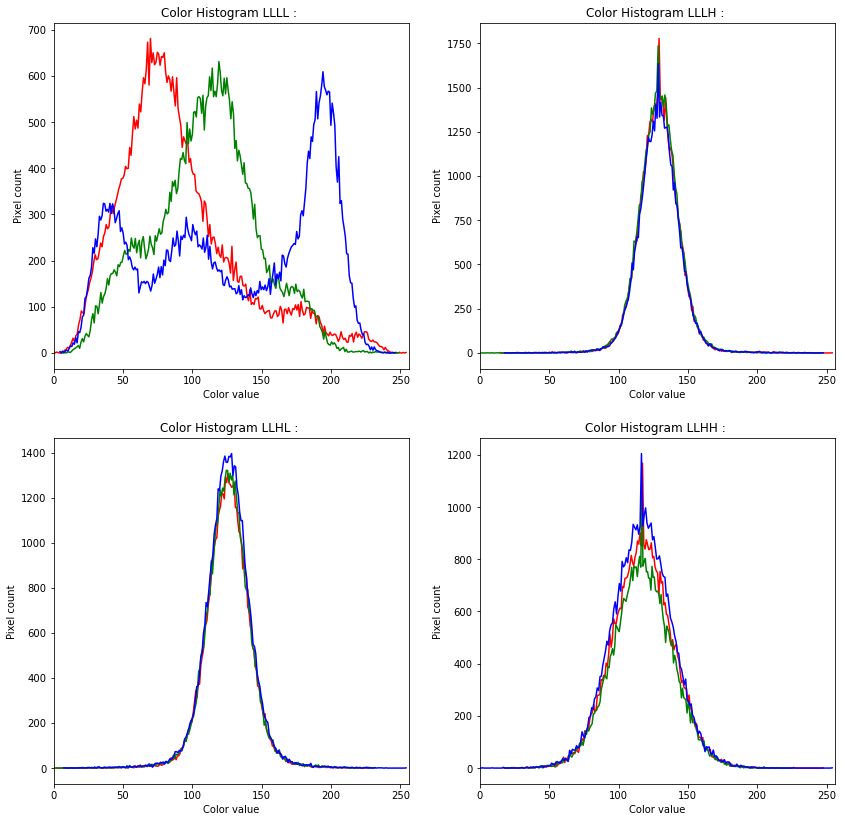

In [75]:
fig = plt.figure(figsize = (14, 14))
colors = ['red','green','blue']

temp = scale(LLLL) #LLLL histogram
ax1 = plt.subplot(2,2,1)
plt.xlim([0, 256])
for i in range(3):
    histogram, bins = np.histogram(temp[:,:,i],bins=256)
    plt.plot(bins[0:-1], histogram, color=colors[i])
plt.title("Color Histogram LLLL : ")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

temp = scale(LLLH) #LLLH histogram
ax2 = plt.subplot(2,2,2)
plt.xlim([0, 256])
for i in range(3):
    histogram, bins = np.histogram(temp[:,:,i],bins=256)
    plt.plot(bins[0:-1], histogram, color=colors[i])
plt.title("Color Histogram LLLH : ")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

temp = scale(LLHL) #LLHL histogram
ax1 = plt.subplot(2,2,3)
plt.xlim([0, 256])
for i in range(3):
    histogram, bins = np.histogram(temp[:,:,i],bins=256)
    plt.plot(bins[0:-1], histogram, color=colors[i])
plt.title("Color Histogram LLHL : ")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

temp = scale(LLHH) #LLHH histogram
ax2 = plt.subplot(2,2,4)
plt.xlim([0, 256])
for i in range(3):
    histogram, bins = np.histogram(temp[:,:,i],bins=256)
    plt.plot(bins[0:-1], histogram, color=colors[i])
plt.title("Color Histogram LLHH : ")
plt.xlabel("Color value")
plt.ylabel("Pixel count");

#### As it can be seen with high thresholds you will miss all the details and the output image whould be the lowpass of image and blurry but less noisy on the other hand if you set a really low threshold the noise wouldn't be removed properly and you have a lower SNR. (all results are provided for both Viso and Bayes / Soft and Hard)

#### Highrt threshold Viso

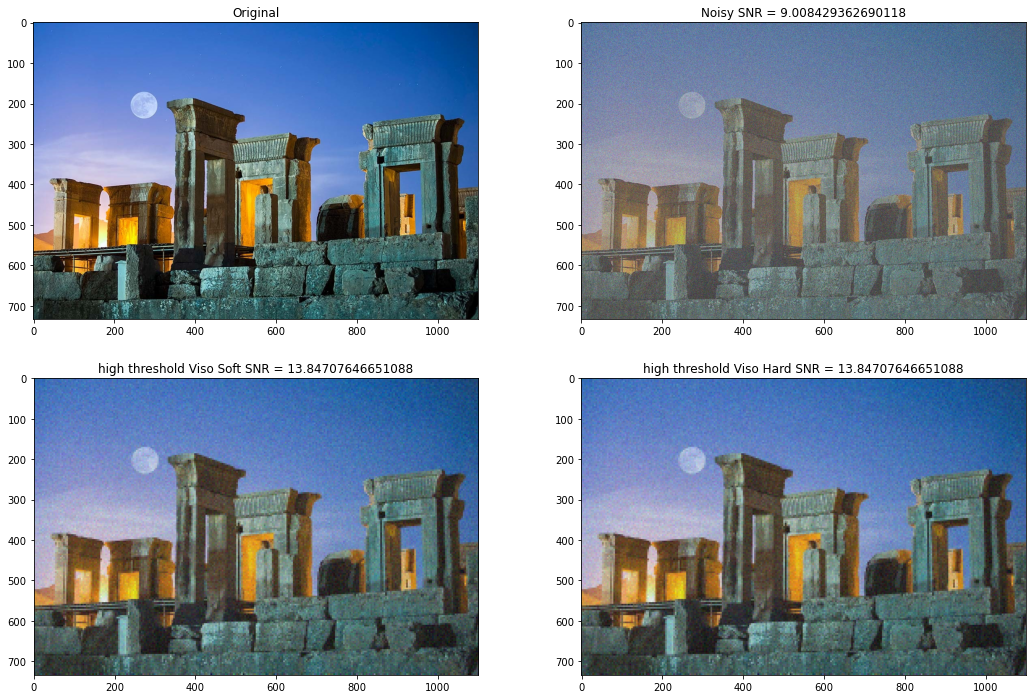

In [76]:
x = 10 # higher

VLLLL = LLLL.copy()

l_viso = x*sigma*np.sqrt(2*np.log(LLLH.shape[0]*LLLH.shape[1])) # viso value from lectures
VLLLH = soft(LLLH,l_viso)
VLLHL = soft(LLHL,l_viso)
VLLHH = soft(LLHH,l_viso)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_viso = x*sigma*np.sqrt(2*np.log(HH.shape[0]*HH.shape[1]))
VLH = soft(LH,l_viso)
VHL = soft(HL,l_viso)
VHH = soft(HH,l_viso)

Viso_soft = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Viso_soft[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

#hard
VLLLL = LLLL.copy()
l_viso = x*sigma*np.sqrt(2*np.log(LLLH.shape[0]*LLLH.shape[1]))
VLLLH = hard(LLLH,l_viso)
VLLHL = hard(LLHL,l_viso)
VLLHH = hard(LLHH,l_viso)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(VHH.shape)
VLL = tVLL[1:368,:,:]

l_viso = x*sigma*np.sqrt(2*np.log(HH.shape[0]*HH.shape[1]))
VLH = hard(LH,l_viso)
VHL = hard(HL,l_viso)
VHH = hard(HH,l_viso)


Viso_hard = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Viso_hard[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')
    
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(img.astype("uint8"))
plt.title("Original")
plt.subplot(222)
plt.imshow(scale(img_noisy).astype("uint8"));
plt.title("Noisy SNR = "+str(SNR(img,img_noisy)))
plt.subplot(223)
plt.imshow(scale(Viso_soft).astype("uint8"));
plt.title("high threshold Viso Soft SNR = "+str(SNR(img,Viso_soft)))
plt.subplot(224)
plt.imshow(scale(Viso_hard).astype("uint8"));
plt.title("high threshold Viso Hard SNR = "+str(SNR(img,Viso_hard)));

higher threshold is going to completely denoise images, and SNR is really high

#### Low Threshold Viso

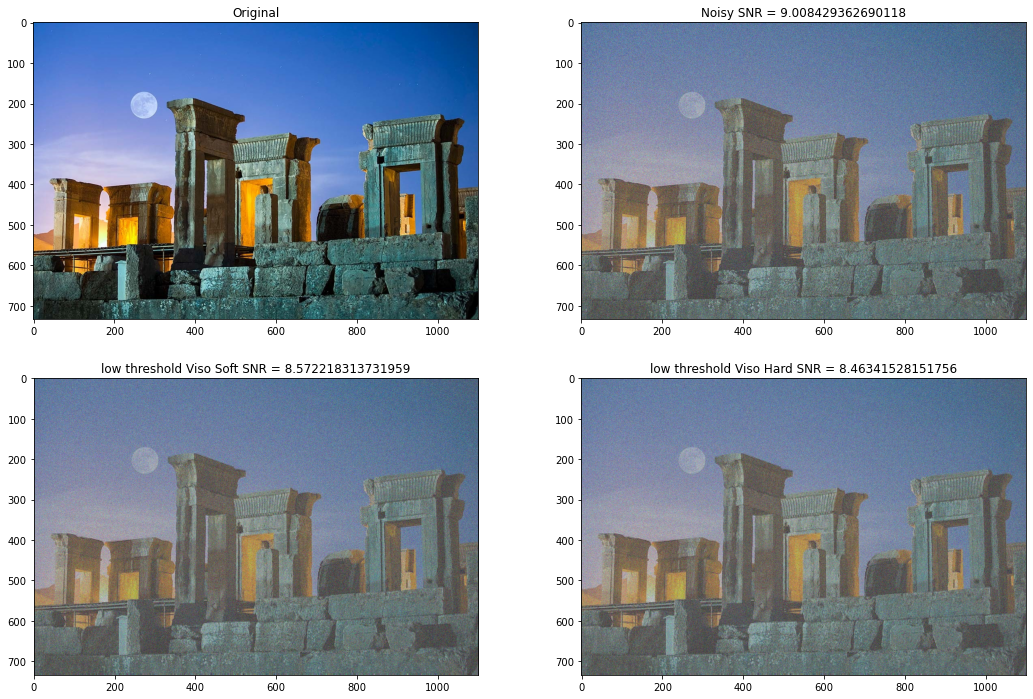

In [77]:
x = 0.01 # lower

VLLLL = LLLL.copy()

l_viso = x*sigma*np.sqrt(2*np.log(LLLH.shape[0]*LLLH.shape[1])) # viso value from lectures
VLLLH = soft(LLLH,l_viso)
VLLHL = soft(LLHL,l_viso)
VLLHH = soft(LLHH,l_viso)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_viso = x*sigma*np.sqrt(2*np.log(HH.shape[0]*HH.shape[1]))
VLH = soft(LH,l_viso)
VHL = soft(HL,l_viso)
VHH = soft(HH,l_viso)

Viso_soft = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Viso_soft[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

#hard
VLLLL = LLLL.copy()
l_viso = x*sigma*np.sqrt(2*np.log(LLLH.shape[0]*LLLH.shape[1]))
VLLLH = hard(LLLH,l_viso)
VLLHL = hard(LLHL,l_viso)
VLLHH = hard(LLHH,l_viso)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(VHH.shape)
VLL = tVLL[1:368,:,:]

l_viso = x*sigma*np.sqrt(2*np.log(HH.shape[0]*HH.shape[1]))
VLH = hard(LH,l_viso)
VHL = hard(HL,l_viso)
VHH = hard(HH,l_viso)


Viso_hard = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Viso_hard[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')
    
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(img.astype("uint8"))
plt.title("Original")
plt.subplot(222)
plt.imshow(scale(img_noisy).astype("uint8"));
plt.title("Noisy SNR = "+str(SNR(img,img_noisy)))
plt.subplot(223)
plt.imshow(scale(Viso_soft).astype("uint8"));
plt.title("low threshold Viso Soft SNR = "+str(SNR(img,Viso_soft)))
plt.subplot(224)
plt.imshow(scale(Viso_hard).astype("uint8"));
plt.title("low threshold Viso Hard SNR = "+str(SNR(img,Viso_hard)));

low threshold is adding a more noise and SNR is actually even lower than noisy image itself :) (as expected)

#### High Thershold Bayes

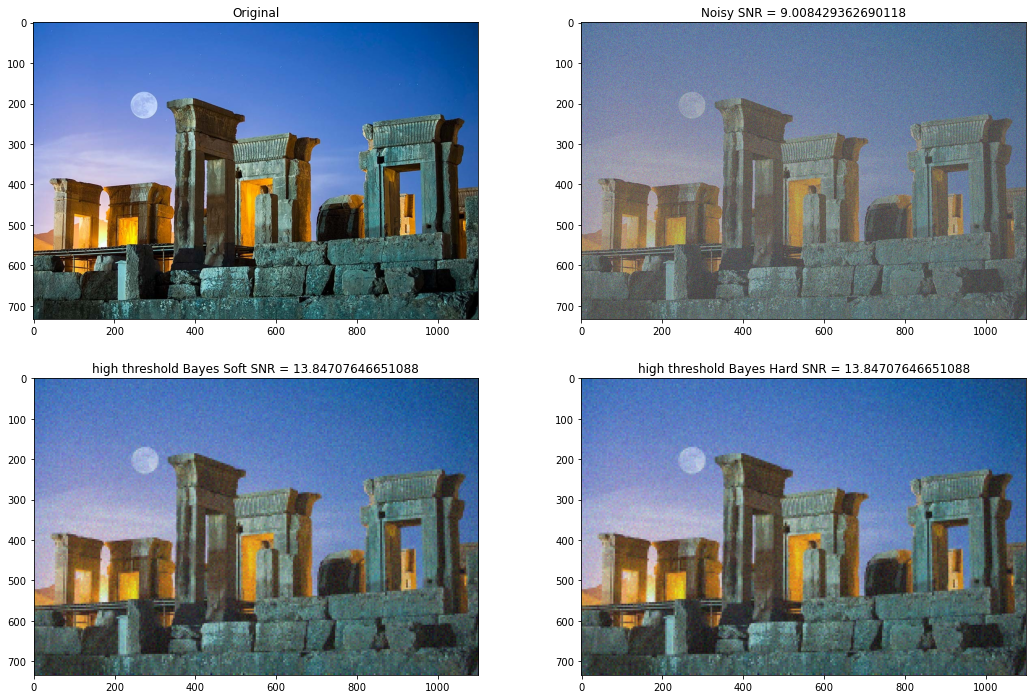

In [78]:
x = 10

VLLLL = LLLL.copy()
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLLH)**2-sigma**2)) # bayes value from slides
VLLLH = soft(LLLH,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLHL)**2-sigma**2))
VLLHL = soft(LLHL,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLHH)**2-sigma**2))
VLLHH = soft(LLHH,l_bayes)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LH)**2-sigma**2))
VLH = soft(LH,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(HL)**2-sigma**2))
VHL = soft(HL,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(HH)**2-sigma**2))
VHH = soft(HH,l_bayes)

Bayes_soft = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Bayes_soft[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')
    
#hard 
VLLLL = LLLL.copy()
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLLH)**2-sigma**2))
VLLLH = hard(LLLH,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLHL)**2-sigma**2))
VLLHL = hard(LLHL,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLHH)**2-sigma**2))
VLLHH = hard(LLHH,l_bayes)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LH)**2-sigma**2))
VLH = hard(LH,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(HL)**2-sigma**2))
VHL = hard(HL,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(HH)**2-sigma**2))
VHH = hard(HH,l_bayes)

Bayes_hard = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Bayes_hard[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')
    
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(img.astype("uint8"))
plt.title("Original")
plt.subplot(222)
plt.imshow(scale(img_noisy).astype("uint8"));
plt.title("Noisy SNR = "+str(SNR(img,img_noisy)))
plt.subplot(223)
plt.imshow(scale(Bayes_soft).astype("uint8"));
plt.title("high threshold Bayes Soft SNR = "+str(SNR(img,Bayes_soft)))
plt.subplot(224)
plt.imshow(scale(Bayes_hard).astype("uint8"));
plt.title("high threshold Bayes Hard SNR = "+str(SNR(img,Bayes_hard)));

again with higher threshold you completely denoise image with really high SNR

#### Low Threshold Bayes

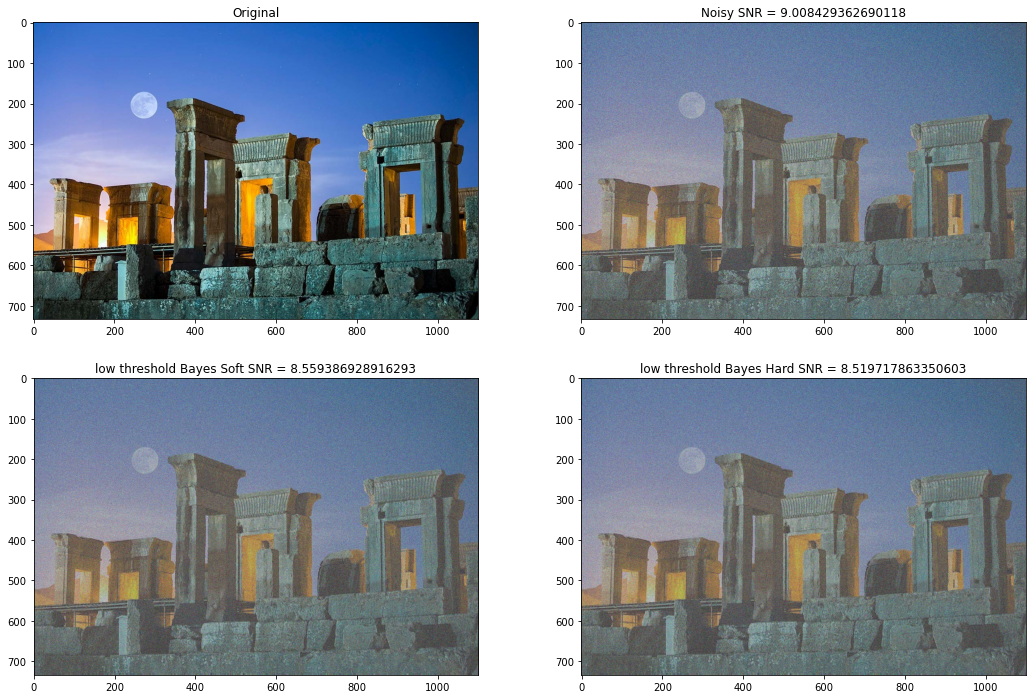

In [79]:
x = 0.01

VLLLL = LLLL.copy()
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLLH)**2-sigma**2)) # bayes value from slides
VLLLH = soft(LLLH,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLHL)**2-sigma**2))
VLLHL = soft(LLHL,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLHH)**2-sigma**2))
VLLHH = soft(LLHH,l_bayes)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LH)**2-sigma**2))
VLH = soft(LH,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(HL)**2-sigma**2))
VHL = soft(HL,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(HH)**2-sigma**2))
VHH = soft(HH,l_bayes)

Bayes_soft = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Bayes_soft[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')
    
#hard 
VLLLL = LLLL.copy()
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLLH)**2-sigma**2))
VLLLH = hard(LLLH,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLHL)**2-sigma**2))
VLLHL = hard(LLHL,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LLHH)**2-sigma**2))
VLLHH = hard(LLHH,l_bayes)

tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(LL.shape)
VLL = tVLL[1:368,:,:]

l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(LH)**2-sigma**2))
VLH = hard(LH,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(HL)**2-sigma**2))
VHL = hard(HL,l_bayes)
l_bayes = x*sigma**2/np.sqrt(max(1e-20,np.std(HH)**2-sigma**2))
VHH = hard(HH,l_bayes)

Bayes_hard = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Bayes_hard[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')
    
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(img.astype("uint8"))
plt.title("Original")
plt.subplot(222)
plt.imshow(scale(img_noisy).astype("uint8"));
plt.title("Noisy SNR = "+str(SNR(img,img_noisy)))
plt.subplot(223)
plt.imshow(scale(Bayes_soft).astype("uint8"));
plt.title("low threshold Bayes Soft SNR = "+str(SNR(img,Bayes_soft)))
plt.subplot(224)
plt.imshow(scale(Bayes_hard).astype("uint8"));
plt.title("low threshold Bayes Hard SNR = "+str(SNR(img,Bayes_hard)));

For lower thresholds your SNR is getting worse than the noisy image !